<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/ANL488_pct_change_3Oct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import required libraries




In [1]:
# Import required libraries

!pip install pycaret yellowbrick
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns
import pycaret
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
from yellowbrick.regressor import PredictionError

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4015    0  4015    0     0   8267      0 --:--:-- --:--:-- --:--:--  8261
100  517k  100  517k    0     0   434k      0  0:00:01  0:00:01 --:--:--  434k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4091    0  4091    0     0  10392      0 --:--:-- --:--:-- --:--:-- 10409
100  392k  100  392k    0     0   431k      0 --:--:-- --:--:-- --:--:-- 3327k


# Step 2: Download data and prepare main dataframe


In [2]:
# Download data for multiple tickers (SPY, DIA, QQQ, IWM, XLK)
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
dfs = {}

for ticker in tickers:
    # Download historical data
    df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
    df.reset_index(inplace=True)
    dfs[ticker] = df

# Choose the main dataset for demonstration, SPY
data = dfs["SPY"].copy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Step 3: Adding technical indicators using TA-Lib

In [3]:
# Adding Technical Indicators using TA-Lib

# Calculate Relative Strength Index (RSI)
data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
data['MACD'], data['MACD_signal'], data['MACD_diff'] = talib.MACD(data['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate Average True Range (ATR)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Calculate Bollinger Bands (BB)
data['bb_bbm'], data['bb_bbh'], data['bb_bbl'] = talib.BBANDS(data['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Calculate Keltner Channel (KC)
data['EMA_KC'] = talib.EMA(data['Adj Close'], timeperiod=20)
data['KC_upper'] = data['EMA_KC'] + (data['ATR'] * 1.5)
data['KC_lower'] = data['EMA_KC'] - (data['ATR'] * 1.5)
data['KC'] = (data['Adj Close'] - data['KC_upper']) / data['Adj Close']
data.drop(columns=['EMA_KC', 'KC_upper', 'KC_lower'], inplace=True)

# Calculate Donchian Channel (DC)
data['DC_upper'] = data['High'].rolling(window=20).max()
data['DC_lower'] = data['Low'].rolling(window=20).min()
data['DC_middle'] = (data['DC_upper'] + data['DC_lower']) / 2

# Calculate On-Balance Volume (OBV)
data['OBV'] = talib.OBV(data['Adj Close'], data['Volume'])

# Calculate Chaikin Money Flow (CMF)
cmf_period = 20
data['Money_Flow_Multiplier'] = ((data['Adj Close'] - data['Low']) - (data['High'] - data['Adj Close'])) / (data['High'] - data['Low'])
data['Money_Flow_Volume'] = data['Money_Flow_Multiplier'] * data['Volume']
data['CMF'] = data['Money_Flow_Volume'].rolling(window=cmf_period).sum() / data['Volume'].rolling(window=cmf_period).sum()

# Calculate the Stochastic Oscillator
data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Adj Close'],
                                               fastk_period=14,  # The %K period
                                               slowk_period=3,   # The %K slowing period
                                               slowk_matype=0,   # Moving average type for %K (0 = SMA)
                                               slowd_period=3,   # The %D period
                                               slowd_matype=0)   # Moving average type for %D (0 = SMA)

# Calculate the Average Directional Index (ADX)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Step 4: Calculate the daily percentage change using the previous day's adjusted close


In [4]:
data['Previous_Day_Adj_Close'] = data['Adj Close'].shift(1)  # Shifting to get the previous day's close
data['Daily_Percentage_Change'] = ((data['Adj Close'] - data['Previous_Day_Adj_Close']) / data['Previous_Day_Adj_Close']) * 100

In [5]:
# Removing rows with NaN values (first row will have NaN due to the shift)
data.dropna(subset=['Daily_Percentage_Change'], inplace=True)

# Drop the unnecessary 'Previous_Day_Adj_Close' column
data.drop(columns=['Previous_Day_Adj_Close'], inplace=True)

# Step 5: Create lag features

In [6]:
# List of features to create lag features (exlcude "Adj Close")
features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal',
                   'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh', 'bb_bbl', 'KC',
                   'DC_upper', 'DC_lower', 'DC_middle','OBV','CMF','stoch_k','stoch_d','ADX']

# Number of lag days to create
lag_days = 20

# Function to create lagged features
def create_lagged_features(df, lag_days, columns):
    for col in columns:
        for lag in range(1, lag_days + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Apply lagged features
data = create_lagged_features(data, lag_days, features_to_lag)
data.dropna(inplace=True)

# Check the resulting DataFrame to confirm new columns
print(data.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-03-20  140.050003  140.610001  139.639999  140.440002  111.839760   
2012-03-21  140.520004  140.649994  139.919998  140.210007  111.656647   
2012-03-22  139.179993  139.550003  138.740005  139.199997  110.852295   
2012-03-23  139.320007  139.809998  138.550003  139.649994  111.210663   
2012-03-26  140.649994  141.610001  140.600006  141.610001  112.771507   

               Volume        RSI      MACD  MACD_signal  MACD_diff  ...  \
Date                                                                ...   
2012-03-20  121729700  71.356427  1.443670     1.252665   0.191006  ...   
2012-03-21  122388400  69.497268  1.432617     1.288655   0.143962  ...   
2012-03-22  135216700  61.871470  1.343465     1.299617   0.043848  ...   
2012-03-23  120521000  63.778476  1.286895     1.297073  -0.010177  ...   
2012-03-26  120164000  70.66118

In [7]:
# Drop features that are not lagged
columns_to_drop = ['Open','High','Low','Close','Adj Close','Volume', 'RSI', 'MACD',
                   'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'KC','DC_upper',
                   'DC_lower', 'DC_middle','OBV','CMF','Money_Flow_Multiplier',
                   'Money_Flow_Volume','stoch_k','stoch_d','ADX']

data.drop(columns=columns_to_drop, inplace=True)
data.fillna(method='ffill', inplace=True)

# Step 6: Split the data into train, validation, and test sets

In [8]:
# Split into training, validation, and test sets
train_data = data[data.index < "2022-01-01"]
validation_data = data[(data.index >= "2022-01-01") & (data.index < "2023-01-01")]
test_data = data[data.index >= "2023-01-01"]

# Display the sizes of each set to ensure proper segregation
print(f"Training set: {train_data.shape}")
print(f"Validation set: {validation_data.shape}")
print(f"Test set: {test_data.shape}")

Training set: (2464, 361)
Validation set: (251, 361)
Test set: (250, 361)


# Step 7: Identify important features using RandomForest

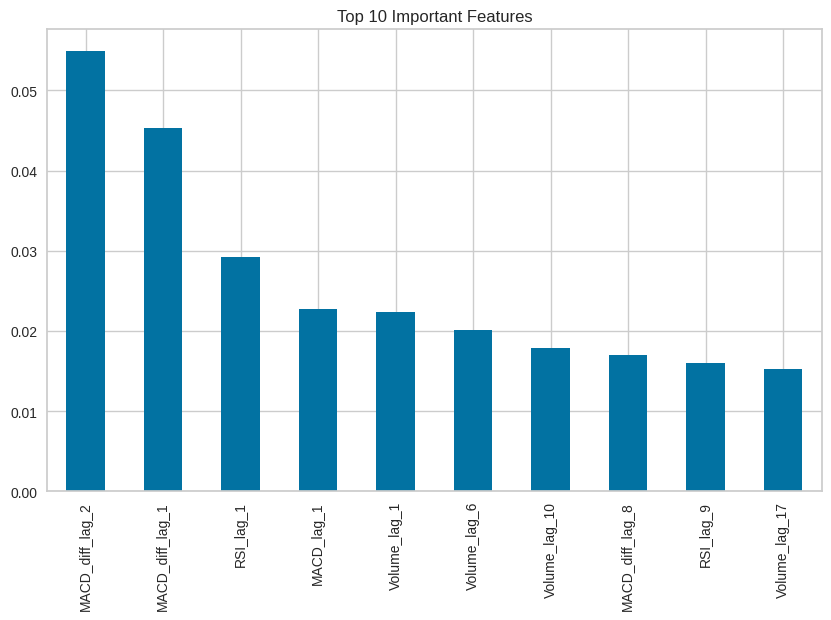

['MACD_diff_lag_2',
 'MACD_diff_lag_1',
 'RSI_lag_1',
 'MACD_lag_1',
 'Volume_lag_1',
 'Volume_lag_6',
 'Volume_lag_10',
 'MACD_diff_lag_8',
 'RSI_lag_9',
 'Volume_lag_17',
 'MACD_diff_lag_6',
 'RSI_lag_2',
 'MACD_diff_lag_7',
 'MACD_diff_lag_3',
 'Volume_lag_9',
 'Volume_lag_2',
 'Volume_lag_3',
 'MACD_diff_lag_9',
 'MACD_diff_lag_11',
 'RSI_lag_3',
 'Volume_lag_11',
 'Volume_lag_8',
 'RSI_lag_7',
 'Volume_lag_5',
 'MACD_signal_lag_1',
 'Volume_lag_20',
 'MACD_diff_lag_10',
 'Volume_lag_4',
 'Volume_lag_7',
 'MACD_lag_2',
 'Volume_lag_19',
 'Volume_lag_12',
 'RSI_lag_4',
 'MACD_diff_lag_17',
 'Volume_lag_13',
 'Volume_lag_16',
 'Volume_lag_15',
 'RSI_lag_8',
 'Volume_lag_14',
 'MACD_diff_lag_18',
 'MACD_diff_lag_5',
 'MACD_diff_lag_4',
 'MACD_diff_lag_20',
 'Volume_lag_18',
 'RSI_lag_20',
 'RSI_lag_5',
 'ADX_lag_5',
 'ADX_lag_20',
 'MACD_diff_lag_15']

In [9]:
X_train = train_data.drop(columns=['Daily_Percentage_Change'])
y_train = train_data['Daily_Percentage_Change']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Identify important features (features with importance > 0.005, contributes at least 0.5% to the model's predictive ability)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
selected_features = feature_importances[feature_importances > 0.005].index.tolist()

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Important Features')
plt.show()

# Show the selected features
selected_features

In [10]:
# Use only the selected features
train_data_selected = train_data[selected_features + ['Daily_Percentage_Change']]
validation_data_selected = validation_data[selected_features + ['Daily_Percentage_Change']]
test_data_selected = test_data[selected_features + ['Daily_Percentage_Change']]

# Step 8: Setup regression model using PyCaret

In [11]:
# Setup regression model using PyCaret for predicting returns
regression_setup = setup(
    data=train_data_selected,
    target='Daily_Percentage_Change',
    fold_strategy='timeseries',  # Time series cross-validation
    fold=5,                      # Use 5 folds for cross-validation
    session_id=42,
    use_gpu=False,
    data_split_shuffle=False,    # Ensure data is not shuffled
    fold_shuffle=False           # Ensure folds are not shuffled
)

,Description,Value
0,Session id,42
1,Target,Daily_Percentage_Change
2,Target type,Regression
3,Original data shape,"(2464, 50)"
4,Transformed data shape,"(2464, 50)"
5,Transformed train set shape,"(1724, 50)"
6,Transformed test set shape,"(740, 50)"
7,Numeric features,49
8,Preprocess,True
9,Imputation type,simple


# Step 9: Compare models and select the top 3

In [12]:
# Compare different models
best_model = compare_models(n_select=3, sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dummy,Dummy Regressor,0.5696,0.6756,0.7936,-0.0032,0.4544,1.2143,0.0320
huber,Huber Regressor,0.5760,0.6833,0.7996,-0.0221,0.4177,1.5594,0.0900
omp,Orthogonal Matching Pursuit,0.5757,0.6827,0.8004,-0.0302,0.4308,1.4627,0.0560
lasso,Lasso Regression,0.5809,0.6856,0.8028,-0.0394,0.4203,1.6875,0.0540
llar,Lasso Least Angle Regression,0.5809,0.6856,0.8028,-0.0394,0.4203,1.6875,0.0580
lr,Linear Regression,0.5808,0.6859,0.8029,-0.0389,0.4181,1.6620,1.6640
en,Elastic Net,0.5814,0.6862,0.8033,-0.0407,0.4203,1.6942,0.0580
ridge,Ridge Regression,0.6045,0.7371,0.8339,-0.1300,0.3826,2.2241,0.0360
et,Extra Trees Regressor,0.6080,0.7430,0.8362,-0.1319,0.3833,2.2915,1.4180
rf,Random Forest Regressor,0.6149,0.7605,0.8504,-0.1958,0.3920,2.2373,5.6340


Processing:   0%|          | 0/83 [00:00<?, ?it/s]

# Step 10: Evaluate models using the validation set







In [13]:
# Evaluate the models on the validation set
validation_X = validation_data_selected.drop(columns=['Daily_Percentage_Change'])
validation_y = validation_data_selected['Daily_Percentage_Change']

# List to store evaluation results
evaluated_models = []

for model in best_model:
    # Skip DummyRegressor models
    if model.__class__.__name__ == 'DummyRegressor':
        print(f"Skipping model: {model.__class__.__name__}")
        continue

    # Fine-tune the model using 5-fold cross-validation
    tuned_model = tune_model(model, optimize='RMSE', fold=5)

    # Make predictions on the validation set using the tuned model
    validation_predictions = predict_model(tuned_model, data=validation_X)

    # Calculate RMSE and R² on the validation set
    val_rmse = np.sqrt(mean_squared_error(validation_y, validation_predictions['prediction_label']))
    val_r2 = r2_score(validation_y, validation_predictions['prediction_label'])

    print(f"Validation RMSE for tuned model {model.__class__.__name__}: {val_rmse}")
    print(f"Validation R² Score for tuned model {model.__class__.__name__}: {val_r2}")

    # Append the tuned model and its performance to the list
    evaluated_models.append((tuned_model, val_rmse, val_r2))

# Sort the evaluated models by RMSE in ascending order
evaluated_models.sort(key=lambda x: x[1])

# Select top 3 models based on the lowest RMSE
top_models = [model[0] for model in evaluated_models[:3]]

print("Top models successfully fine-tuned and selected.")


Skipping model: DummyRegressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5356,0.4910,0.7007,-0.0749,0.3700,1.8133
1,0.5940,0.6725,0.8201,-0.0175,0.4279,1.3074
2,0.7010,0.9390,0.9690,0.0097,0.4927,1.8427
3,0.3236,0.2049,0.4526,-0.0070,0.2818,1.3854
4,0.7214,1.1058,1.0516,-0.0053,0.5145,1.3692
Mean,0.5751,0.6826,0.7988,-0.0190,0.4174,1.5436
Std,0.1431,0.3193,0.2111,0.0293,0.0847,0.2338


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Validation RMSE for tuned model HuberRegressor: 1.5337417591730125
Validation R² Score for tuned model HuberRegressor: -0.012667760064447808


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5278,0.4731,0.6879,-0.0358,0.3845,1.6602
1,0.5924,0.6750,0.8216,-0.0213,0.4426,1.2198
2,0.6983,0.9342,0.9666,0.0147,0.5183,1.5852
3,0.3257,0.2110,0.4593,-0.0370,0.2980,1.2638
4,0.7126,1.0966,1.0472,0.0031,0.5295,1.2172
Mean,0.5714,0.6780,0.7965,-0.0152,0.4346,1.3892
Std,0.1406,0.3165,0.2088,0.0208,0.0863,0.1928


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Validation RMSE for tuned model OrthogonalMatchingPursuit: 1.5298001410865716
Validation R² Score for tuned model OrthogonalMatchingPursuit: -0.007469465734351921
Top models successfully fine-tuned and selected.


#Step 11: Test the models and generate error plots

Testing Model 1: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MACD_diff_lag_2',
                                             'MACD_diff_lag_1', 'RSI_lag_1',
                                             'MACD_lag_1', 'Volume_lag_1',
                                             'Volume_lag_6', 'Volume_lag_10',
                                             'MACD_diff_lag_8', 'RSI_lag_9',
                                             'Volume_lag_17', 'MACD_diff_lag_6',
                                             'RSI_lag_2', 'MACD_diff_lag_7',
                                             'MACD_diff_lag_3', 'Volume_lag_9',
                                             'Volume_lag_2', 'Volume...
                                             'RSI_lag_7', 'Volume_lag_5',
                                             'MACD_signal_lag_1',
                                             'Volume_lag_20',
                       

Model 1 - Test RMSE: 0.8282749851731211, Test R² Score: -0.015241493667267125
Testing Model 2: Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MACD_diff_lag_2',
                                             'MACD_diff_lag_1', 'RSI_lag_1',
                                             'MACD_lag_1', 'Volume_lag_1',
                                             'Volume_lag_6', 'Volume_lag_10',
                                             'MACD_diff_lag_8', 'RSI_lag_9',
                                             'Volume_lag_17', 'MACD_diff_lag_6',
                                             'RSI_lag_2', 'MACD_diff_lag_7',
                                             'MACD_diff_lag_3', 'Volume_lag_9',
                                             'Volume_lag_2', 'Volume...
                                             'Volume_lag_11', 'Volume_lag_8',
                                             'RSI_lag_7', 'Volume_lag

Model 2 - Test RMSE: 0.8262571588902372, Test R² Score: -0.010300898693716087


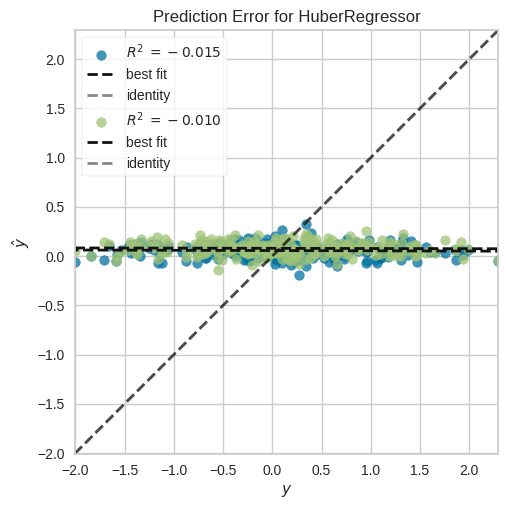

In [18]:
# Ensure that the models are finalized before using them on the test set
final_models = [finalize_model(model) for model in top_models]

# Evaluate the finalized models on the test set
for i, model in enumerate(final_models, start=1):
    print(f"Testing Model {i}: {model}")

    # Drop the 'Daily Percentage Change' column from test_data_selected before making predictions
    test_features = test_data_selected.drop(columns=['Daily_Percentage_Change'])

    # Make predictions on the test set using only the features
    predictions = predict_model(model, data=test_features)

    # Calculate RMSE and R² score on the test set using the actual 'Daily Percentage Change' values
    rmse = np.sqrt(mean_squared_error(test_data_selected['Daily_Percentage_Change'], predictions['prediction_label']))
    r2 = r2_score(test_data_selected['Daily_Percentage_Change'], predictions['prediction_label'])
    print(f"Model {i} - Test RMSE: {rmse}, Test R² Score: {r2}")

    # Plot the prediction error using Yellowbrick (ensure Yellowbrick is installed)
    visualizer = PredictionError(model)
    visualizer.score(test_features, test_data_selected['Daily_Percentage_Change'])
    visualizer.show(outpath=f'prediction_error_model_{i}.png')  # Save the plot as a PNG file

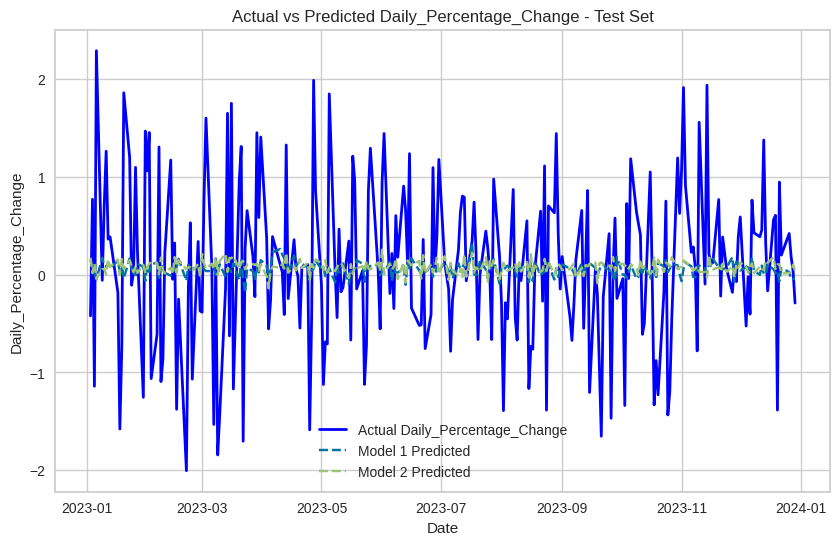

In [15]:
import matplotlib.pyplot as plt

# Assuming you have test_data_selected and predictions from the models
# We'll also assume 'final_models' contains the finalized models for Ridge, Linear, and Bayesian Ridge

# Actual values (from the test set)
actual_values = test_data_selected['Daily_Percentage_Change']

# Create a plot for actual vs. predicted values for each model
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(actual_values.index, actual_values, label='Actual Daily_Percentage_Change', color='blue', linewidth=2)

# Plot predicted values for each model
for i, model in enumerate(final_models, start=1):
    # Make predictions
    test_features = test_data_selected.drop(columns=['Daily_Percentage_Change'])
    predictions = predict_model(model, data=test_features)['prediction_label']

    # Plot predicted values
    plt.plot(actual_values.index, predictions, label=f'Model {i} Predicted', linestyle='--')

# Customize the plot
plt.title('Actual vs Predicted Daily_Percentage_Change - Test Set')
plt.xlabel('Date')
plt.ylabel('Daily_Percentage_Change')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [16]:
predictions

,prediction_label
Date,
2023-01-03,0.174359
2023-01-04,0.016984
2023-01-05,0.115618
2023-01-06,-0.041321
2023-01-09,0.056540
...,...
2023-12-22,0.014263
2023-12-26,0.017431
2023-12-27,0.031762


In [17]:
test_data_selected

,MACD_diff_lag_2,MACD_diff_lag_1,RSI_lag_1,MACD_lag_1,Volume_lag_1,Volume_lag_6,Volume_lag_10,MACD_diff_lag_8,RSI_lag_9,Volume_lag_17,...,MACD_diff_lag_5,MACD_diff_lag_4,MACD_diff_lag_20,Volume_lag_18,RSI_lag_20,RSI_lag_5,ADX_lag_5,ADX_lag_20,MACD_diff_lag_15,Daily_Percentage_Change
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,-1.468283,-1.144747,45.543741,-2.669133,84022200.0,100120900.0,119858000.0,-2.637057,39.915493,65927900.0,...,-2.020982,-1.854121,0.734950,77972200.0,62.909956,44.235660,15.097850,22.636794,-1.508869,-0.420974
2023-01-04,-1.144747,-0.968313,44.155267,-2.734777,74850700.0,59857300.0,79878100.0,-2.266678,40.471469,60737900.0,...,-1.854121,-1.944015,0.183090,65927900.0,55.343120,43.013102,15.146901,22.121065,-1.276135,0.772025
2023-01-05,-0.968313,-0.607772,47.314138,-2.526179,85934100.0,51638200.0,74427200.0,-2.269338,46.323773,81447700.0,...,-1.944015,-1.468283,-0.581506,60737900.0,50.223965,39.337662,15.576615,20.658349,-0.915088,-1.141343
2023-01-06,-0.607772,-0.605207,43.377517,-2.674916,76970500.0,70911500.0,78167400.0,-2.020982,42.016075,75405800.0,...,-1.468283,-1.144747,-1.122507,81447700.0,49.648652,46.393655,15.802270,19.300112,-0.836992,2.293204
2023-01-09,-0.605207,-0.011215,51.932350,-2.083727,104189600.0,66970900.0,100120900.0,-1.854121,44.235660,123782500.0,...,-1.144747,-0.968313,-1.259979,75405800.0,52.350683,45.543741,16.095371,18.285997,-1.384756,-0.056692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.553542,0.453946,70.642741,7.820687,86667500.0,119026000.0,83080900.0,0.041181,71.875233,63146000.0,...,0.798108,0.882804,1.941226,62115000.0,71.875317,77.812556,47.230836,31.256847,0.632828,0.200974
2023-12-26,0.453946,0.360625,71.405156,7.817521,67126600.0,141319300.0,65002200.0,0.478689,73.881855,79752700.0,...,0.882804,1.008491,1.569414,63146000.0,70.178823,79.662830,48.448051,32.130395,0.360448,0.422254
2023-12-27,0.360625,0.341688,72.995189,7.884007,55387000.0,70375300.0,68327600.0,0.765907,78.818288,89097900.0,...,1.008491,0.553542,1.233669,79752700.0,70.589096,81.471752,49.750024,33.053424,0.107745,0.180810
